Minimum element length reached; terminating refinement.


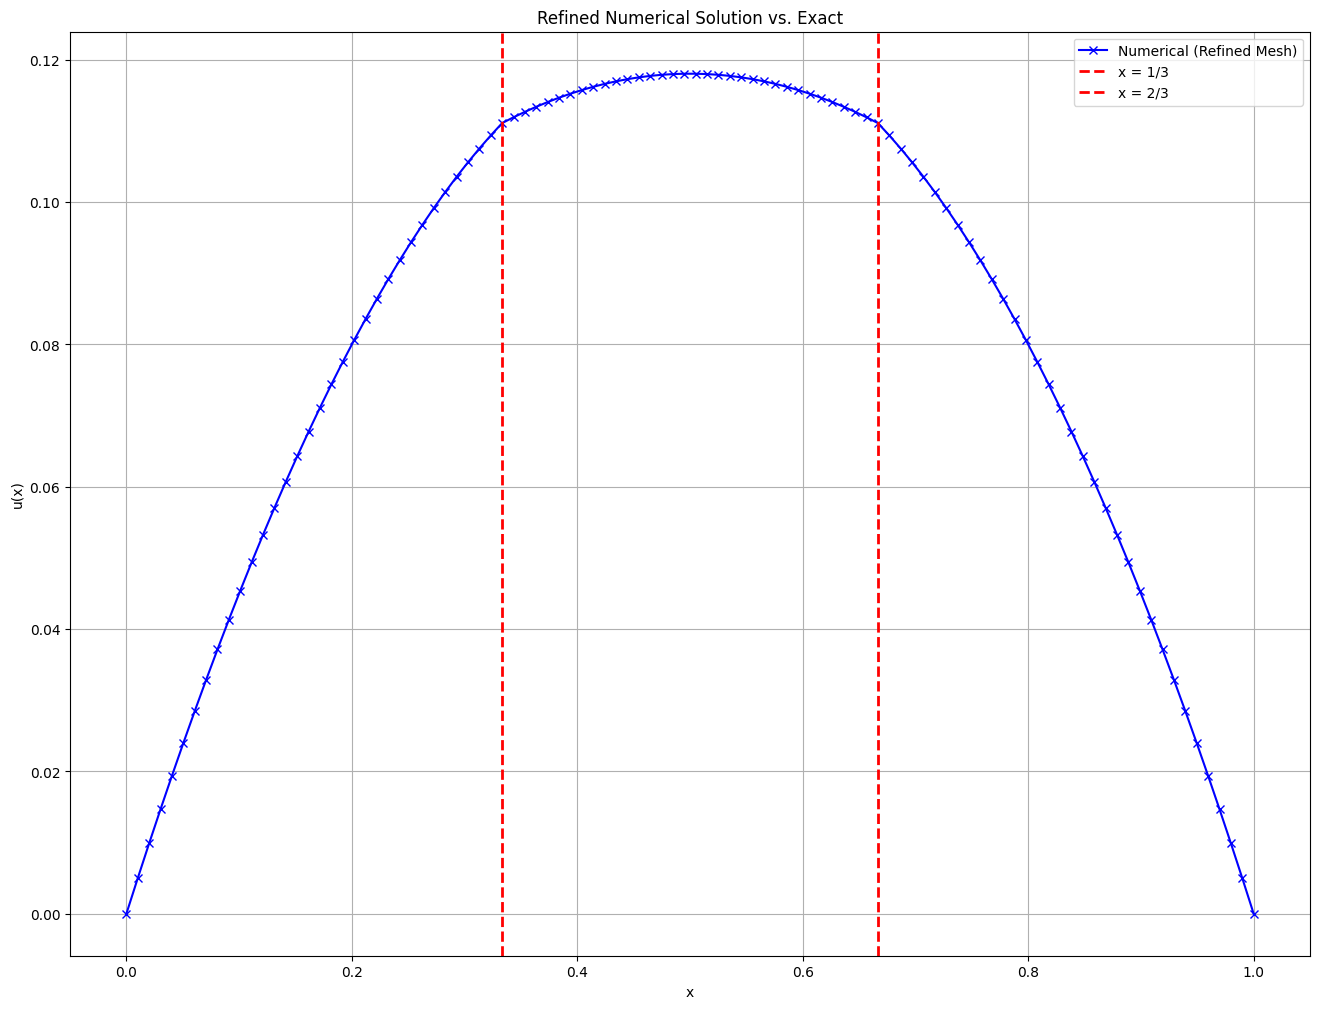

In [1]:
import gauleg as gl 
import sympy as sp 
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
import Solver2 as sl 
from scipy.interpolate import interp1d

%load_ext autoreload

%autoreload 2


# Generating Delta Vector

In [2]:
def interpolation_for_u_h(nodal, mesh, num_points):
  """
  Given the nodal solution 'nodal' computed on the refined mesh 'mesh',
  return the solution values at observation nodes computed as a uniform grid
  over [0,1] with num_points points.

  Assumes that every observation node exactly exists in the mesh.

  Parameters:
    nodal     : array-like, the computed solution at each mesh node.
    mesh      : array-like, the coordinates of the mesh nodes.
    num_points: int, number of observation points (e.g., 8).

  Returns:
    obs_values: np.array, the solution values corresponding to each observation node.

  Raises:
    ValueError if any observation node is not found in the mesh.
  """
  nodal = sl.assemble_nodal_values(nodal)
  mesh = np.asarray(mesh)
  nodal = np.asarray(nodal)
  
  # Compute observation nodes uniformly over [0,1]
  obs_nodes = np.linspace(0.0, 1.0, num_points)
  obs_values = np.zeros(num_points)

  for i, x_obs in enumerate(obs_nodes):
    idx = np.where(mesh == x_obs)[0]
    if idx.size == 0:
      raise ValueError(f"Observation node {x_obs} not found in the mesh.")
    obs_values[i] = nodal[idx[0]]

  return obs_values


def cov_matrix(sigma, num_points):
  sigma = (sigma ** 2) * np.eye(num_points)
  return sigma



In [3]:
def add_noise(observations_at_xi, num_points, sigma):
    """
    Adds a normally distributed noise, theta
    to observations from the forward solver.

    Arguments:
    observations_at_xi : observations at predetermined xi using interplotion. 
    num_points : how big your covariance matrix is 

    Returns:
    Delta : Array of Noisy observations.
    
    """
    sigma = cov_matrix(sigma, num_points)
    noise = np.random.multivariate_normal(np.zeros(num_points), sigma)
    delta = observations_at_xi + noise 
    return delta



# Define Likelihood Function 

In [4]:
def phi(observations, predicted, sigma, num_points) :
    '''
    For a set of predetermined points xi -- obtained via np.linspace,
    this function defines the likelihood function 

    Arguments:
    observations: Generated noisy observation using beta_true -- corresponds to y in literature
    predicted: For a proposed beta_i, we compute the noisy observation using the forward solver 
    -- corresponds to g(beta_i) in literature

    Returns: 
    Likelihood function that is proportional to the prior distribution
    
    '''
    covariance_matrix = cov_matrix(sigma, num_points)
    diff = predicted - observations
    covariance_matrix_inv = np.linalg.inv(covariance_matrix) # this supposed to be identity
    val = 0.5 * diff.T @ covariance_matrix_inv @ diff
    return val
# 2 cases, 1. denominator very close to 0 or both is 0. need to check if its one or both. 


In [5]:
def compute_A(phi_0, phi_i, sigma):

    val = np.exp(phi_0 - phi_i)
    
    return val

# MCMC algorithm 

In [ ]:
def MCMC(beta_true, number_of_iter, burn_in, sigma, num_points): 
    '''
    Builds a Markov Chain 

    Key Steps:
    1. Initialise a choice of Beta, beta_0 
    2. Compute likelihood of beta_0, using delta and beta_0_predicted
    3. Initialise the loop.
        - we propose a new beta_i from x* ~ Uniform(0.15, 0.85) and r ~ Uniform(0, 0.15)
        - compute y_i and g(beta_i)
        - compute likelihood using {y_i and g(beta_i)}
        - set alpha = min{1, likelihood }
    '''
    # set seed 
    np.random.seed(42)
    # range of uniform distribution 
    x_star_range = (0.3, 0.7) # reference = 0.65
    r_true = 0.1 # reference = 0.15 , range = (0.1, 0.2)
    chain = []
    # compute delta 
    mesh_true , c_sol_true = sl.refinement_loop(0.001, beta_true) 
    y_true = interpolation_for_u_h(c_sol_true, mesh_true, num_points)
    delta = add_noise(y_true, num_points, sigma)

    # draw first copy of beta --> beta_0

    beta_0 = np.array([
            np.random.uniform(*x_star_range),
            r_true 
        ])
    print("Beta_0:", beta_0)
    
    # initialise current observations and likelihood 
    mesh_0, c_sol_0 = sl.refinement_loop(0.1, beta = beta_0)
    y_0 = interpolation_for_u_h(c_sol_0, mesh_0, num_points)
    phi_0 = phi(delta, y_0, sigma, num_points)
    print("phi_0:", phi_0)
    
    iter_count = 0
    acceptance_count = 0 
    acceptance_prob_history = []

    for i in range(number_of_iter):
        beta_proposal = np.array([
            np.random.uniform(*x_star_range),
            r_true
        ])
        print("beta proposal:", beta_proposal)
        mesh_proposal, c_sol_proposal = sl.refinement_loop(0.1, beta = beta_proposal)
        y_proposal = interpolation_for_u_h(c_sol_proposal, mesh_proposal, num_points)
        phi_proposal = phi(delta, y_proposal, sigma, num_points)
        print("phi proposal:", phi_proposal)
        # compute acceptance probability 
        A = compute_A(phi_0, phi_proposal, sigma)
        acceptance_prob = min(1, A)
        acceptance_prob_history.append(acceptance_prob)
        print("acceptance probablity:", acceptance_prob)
        
        # Accept or reject the proposal
        if np.random.rand() < acceptance_prob:
            beta_0 = beta_proposal # update the current state as the last accepted proposal
            y_0 = y_proposal # update the current observations to the last accepted observation
            phi_0 = phi_proposal
            acceptance_count += 1
        
        # Record the current state.
        chain.append(beta_0.copy())
        print("Chain length:", len(chain))
    
    chain = np.array(chain)
    # Compute the MCMC estimate as the mean of the samples after burn-in.
    beta_mcmc = np.mean(chain[burn_in:], axis=0)
    
    return chain, beta_mcmc, acceptance_prob_history, acceptance_count

In [7]:
number_of_iter = 5000
burn_in = 2000
sigma = 0.01
num_points = 100
beta_true = np.array([0.65, 0.1])

chain, beta_mcmc, acceptance_history, acceptance_count = MCMC(beta_true, number_of_iter, burn_in, sigma, num_points)
print("True beta:", beta_true )
print("MCMC estimated beta:", beta_mcmc)
print("Acceptance Probability History:", acceptance_history)
print("Acceptance Count:", acceptance_count)

Minimum element length reached; terminating refinement.
Beta_0: [0.4669644 0.1      ]
phi_0: 56.79974054980185
beta proposal: [0.38884312 0.1       ]


C:\Users\Espietsp\AppData\Local\Temp\ipykernel_18192\2839755143.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs_values[i] = nodal[idx[0]]


phi proposal: 55.07244806763244
acceptance probablity: 1
Chain length: 1
beta proposal: [0.43504607 0.1       ]
phi proposal: 56.64333065220159
acceptance probablity: 0.20786164589452533
Chain length: 2
beta proposal: [0.42928117 0.1       ]
phi proposal: 56.40031162864642
acceptance probablity: 0.2650429048480952
Chain length: 3
beta proposal: [0.58120758 0.1       ]
phi proposal: 46.5731244879163
acceptance probablity: 1
Chain length: 4
beta proposal: [0.68871283 0.1       ]
phi proposal: 43.33063576703717
acceptance probablity: 1
Chain length: 5
beta proposal: [0.40071292 0.1       ]
phi proposal: 55.49707538828989
acceptance probablity: 5.20214445990765e-06
Chain length: 6
beta proposal: [0.42035132 0.1       ]
phi proposal: 56.09931282062267
acceptance probablity: 2.8486166895987015e-06
Chain length: 7
beta proposal: [0.31475478 0.1       ]
phi proposal: 53.025672678074386
acceptance probablity: 6.158840651659321e-05
Chain length: 8
beta proposal: [0.50107161 0.1       ]
phi propo

In [8]:
mean_beta = np.mean(chain, axis=0)
mean_beta_sq = np.mean(chain**2, axis=0)
var_beta = mean_beta_sq - mean_beta**2
var_beta

array([ 3.74897650e-04, -2.08340289e-15])

# DataLogging : 
```
1. Chain Length of 10000 with 1000 burn in takes ~~ 900 mins --> 15 hours 
   Params and Results: 
    number_of_iter = 10000 
    burn_in = 1000 
    sigma = 0.05 
    num_points = 8 
    beta_true = np.array([0.23, 0.13]) 
    MCMC estimated beta: [0.28158902 0.06286484]
    variance(beta) = array([0.00919061, 0.00088973])
Comments: Phi and Sigma computation is wrong, the area of acceptance is too small 
Run Profilier 
Heat map
Check computation of Phi and A 
fix right hand side at 1 
set epislon to be 0.01

2. Chain length of 1000 with 200 burn in 
    Params and Results:
    
```

curious about the following 
is there a ways to restrict the range of the sampling when we know that it is good? 

In [9]:
from concurrent.futures import ProcessPoolExecutor

def run_single_chain(seed, beta_true, number_of_iter, burn_in, sigma, num_points):
    # Set the random seed to ensure independent chains.
    np.random.seed(42)
    return MCMC(beta_true, number_of_iter, burn_in, sigma, num_points)

def run_multiple_chains(n_chains, beta_true, number_of_iter, burn_in, sigma, num_points):
    seeds = np.random.randint(0, 10000, size=n_chains)
    chains = []
    beta_mcmcs = []
    acceptance_histories = []
    acceptance_counts = []
    
    # Run chains in parallel using ProcessPoolExecutor
    with ProcessPoolExecutor() as executor:
        # Submit all the chains concurrently
        futures = [
            executor.submit(run_single_chain, seed, beta_true, number_of_iter, burn_in, sigma, num_points)
            for seed in seeds
        ]
        # Collect results as they complete
        for future in futures:
            chain, beta_mcmc, acceptance_prob_history, acceptance_count = future.result()
            chains.append(chain)
            beta_mcmcs.append(beta_mcmc)
            acceptance_histories.append(acceptance_prob_history)
            acceptance_counts.append(acceptance_count)
    
    return chains, beta_mcmcs, acceptance_histories, acceptance_counts

if __name__ == '__main__':
    n_chains = 4
    number_of_iter = 10000
    burn_in = 1000
    sigma = 0.1 
    num_points = 100
    beta_true = np.array([0.5, 1/6])
    chains, beta_mcmcs, acceptance_histories, acceptance_counts = run_multiple_chains(
        n_chains, beta_true, number_of_iter, burn_in, sigma, num_points
    )
print("True beta:", beta_true )
print("MCMC estimated beta:", beta_mcmcs)
print("Acceptance Probability History:", acceptance_histories)
print("Acceptance Count:", acceptance_counts)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.